# Predictive Modelling of Proteomics using a Transformer Model

## Task Type and Model Decision
This task is a regression task, where one type of omics data is predicted using others. Both VAEs and Transformers are suitable choices: VAEs excel with noisy data and handle missing values well, while Transformers are powerful for capturing complex interactions between features through their self-attention mechanism.

I selected a Transformer model because the multi-head attention can learn different types of relationships between omics data features and capturing various correlations that might exist. The self-attention mechanism allows the model to identify important feature interactions, which I think are important in multi-omics data integration. While VAEs would also be suitable, particularly for handling noise and missing values, the potential complex interactions between omics data features made Transformers my preferred choice.

## Data
The aim is to use multiple input omics datasets to predict proteomics data. Input omics data was selected by iteratively testing combinations to determine which best predicted proteomics. This indicated that transcriptomics data only as the optimal input combination for proteomics prediction.

## Plan
The approach follows a systematic comparison between a baseline MLP model and the Transformer architecture:

#### In EMBL_transformer_explore.ipynb
1. [Inspect data](#inspect-data);
2. [Create a simple MLP model](#baseline-mlp) as a baseline;
3. [Develop Transformer models](#transformer-models) with different fusion strategies and activation functions;
4. [Perform hyperparameter tuning](#hyperparameter-tuning);
5. [Conduct progressive input omics selection](#omics-selection);
6. [Create comprehensive loop](#evaluation-loop) to iterate through steps 3-5, obtaining metrics to determine the best Transformer model for comparison with the baseline MLP;

#### In EMBL_transformer_best_model.ipynb
7. [Select best-performing model](#best-performing);
8. [Analyse best-predicted proteomic features](#feature-analysis);


## Results
- The [baseline MLP model](#results-MLP) performed quite well already, with an R^2 ~0.83, an RMSE ~0.69, and prediction errors that are roughly Normally distributed.
- The best [Transformer model](#results-transformer) demonstrated that using transcriptomics data only as input omics data performed best, with R^2 ~0.83. However, rerunning the algorithm shows some variability in the best performing hyperparameters, such as fusion method selected. In addition, the Transformer model does not significantly outperform the baseline MLP model. Moving forward, cross-validation and improved data handling (e.g. outlier handling) would be worth exploring. 
- The results of the [feature analysis](#results-feature-analysis) showed significant correlation values >0.5 between the predicted and actual values. However, the R^2 values are low, indicating that while the general trends in protein expression are captured, the model does not accurately predict the exact values. 

## Future Work
Given more time, I would implement:

1. Cross-validation for more robust model evaluation;
2. Enhanced data handling, particularly for outliers. Despite the task stating the data was "processed and cleaned, so you can use them directly" I encountered outliers that might affect results. Going forward, I would address these outliers prior to modelling;
3. Development of ensemble methods to potentially improve prediction accuracy.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.gridspec as gridspec

from scipy.stats import zscore, pearsonr

In [2]:
from transformer_multiomics.config import MODEL_PATH, RESULT_PATH, DATA_PATH
from transformer_multiomics.data.data_loader import ensure_directories_exist, load_datasets

# Ensure directories exist
ensure_directories_exist(MODEL_PATH, RESULT_PATH, DATA_PATH)

# Load datasets
datasets = load_datasets()
print("Available datasets:", datasets.keys())

Directory exists: /home/jantine/Projects/transformer_multiomics/models
Directory exists: /home/jantine/Projects/transformer_multiomics/results
Directory exists: /home/jantine/Projects/transformer_multiomics/data
Available datasets: dict_keys(['methylation', 'metabolomics', 'proteomics', 'transcriptomics', 'cnv'])


# Inspect Data <a id="inspect-data"></a>

This part includes:
- Loading the data;
- Quick scan through data to get an intuition;
- Visualise the distribution and characteristics of the data:
    - Distribution plots: skewness, normality, etc.
    - Boxplots: median, quartiles, and outliers for first 20 features.
    - Heatmap: patterns, clusters, and correlations between samples and features.
    - Z-score: outlier detection.
    - PCA: the PC that explains most of the variance.

In [3]:
# Get the patient ID column name
patient_id_col = list(datasets.values())[0].columns[0]

# Reference/Target dataset, i.e. proteomics
reference = "proteomics"
reference_df = datasets[reference]
reference_ids = list(reference_df[patient_id_col])

# Check all datasets
for name, df in datasets.items():
    current_ids = list(df[patient_id_col])

    # Check if patient IDs are the same
    same_ids = set(reference_ids) == set(current_ids)
    print(f"{name}: Same IDs as {reference}: {same_ids}")

    # Check if patient IDs are in the same order
    same_order = reference_ids == current_ids
    print(f"{name}: Same order as {reference}: {same_order}")
    print(f"-------------------------------------------------\n")

methylation: Same IDs as proteomics: True
methylation: Same order as proteomics: True
-------------------------------------------------

metabolomics: Same IDs as proteomics: True
metabolomics: Same order as proteomics: True
-------------------------------------------------

proteomics: Same IDs as proteomics: True
proteomics: Same order as proteomics: True
-------------------------------------------------

transcriptomics: Same IDs as proteomics: True
transcriptomics: Same order as proteomics: True
-------------------------------------------------

cnv: Same IDs as proteomics: True
cnv: Same order as proteomics: True
-------------------------------------------------



In [4]:
print(datasets["proteomics"].shape)
datasets["proteomics"].head()

(175, 4923)


,Unnamed: 0,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,AARS1,AARS2,AARSD1,...,ZNF830,ZNHIT2,ZNRD2,ZNRF2,ZPR1,ZRANB2,ZW10,ZWILCH,ZWINT,ZYX
0,SIDM00046,3.35516,2.47970,2.64814,3.42747,2.29730,2.79989,5.03959,4.36283,2.83884,...,0.94939,1.96832,4.87203,3.54926,2.74466,3.96470,2.31081,1.44500,2.23063,4.87281
1,SIDM00047,3.47470,1.78254,3.52149,2.92188,1.37197,2.97951,5.14901,3.88597,3.55916,...,0.84154,1.78003,3.42515,2.79853,3.20215,4.02278,2.24471,1.87061,1.76904,4.96541
2,SIDM00048,3.56201,2.52743,3.26977,3.48947,2.15151,2.75366,5.11889,3.51744,3.29552,...,1.34557,2.03291,4.14519,3.22756,3.29044,3.98339,2.58220,2.09735,2.47003,4.91925
3,SIDM00098,3.50973,2.33440,3.43963,3.32111,2.48636,3.17103,5.59721,3.94357,3.56998,...,0.81172,1.79803,4.24853,3.12697,3.93978,4.55265,2.63257,1.90050,2.06059,5.91146
4,SIDM00099,3.54051,2.12653,2.91819,2.84000,2.05342,2.33734,4.71901,3.52292,2.09409,...,0.35651,1.80656,3.25177,2.95097,2.55263,3.52448,2.67204,1.77170,1.80426,5.53598


In [5]:
print(datasets["transcriptomics"].shape)
datasets["transcriptomics"].head()

(175, 15279)


,Unnamed: 0,A1BG,A1CF,A2M,A2ML1,A4GALT,AAAS,AACS,AADAC,AADAT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
0,SIDM00046,2.04090,-5.30627,-1.25004,-1.32172,3.00924,5.27339,5.77792,-1.93157,3.19395,...,5.30791,6.61797,1.60898,3.89132,5.07034,1.43384,4.89578,7.85737,6.32957,5.04573
1,SIDM00047,1.01151,-3.45882,-0.39178,-3.98753,3.27545,5.79755,5.27295,0.06323,3.18109,...,5.77799,6.63569,2.52953,4.19684,4.53901,-0.83239,5.21132,7.02936,5.91940,5.83587
2,SIDM00048,0.43384,-4.20756,-0.63528,-1.37044,3.80196,5.79006,5.56590,-1.02246,2.43433,...,5.56682,6.89185,2.52134,4.22761,4.88434,-0.38911,5.10613,7.08207,6.02523,5.65201
3,SIDM00098,1.69118,-4.16117,-0.22028,-4.65767,1.05576,5.66560,5.32404,-2.79352,1.49933,...,5.78098,6.65350,2.05654,3.92582,4.89359,-1.52334,5.17720,7.11551,6.26238,5.83334
4,SIDM00099,1.70960,-4.00844,0.29479,-5.20683,2.16290,5.71212,5.52738,-2.82416,1.96201,...,5.81931,6.61506,2.39253,4.15398,4.57227,-0.64660,5.43610,7.44160,6.32660,5.79604


In [6]:
# Check stats data
datasets["proteomics"].describe()

,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,AARS1,AARS2,AARSD1,AASDHPPT,...,ZNF830,ZNHIT2,ZNRD2,ZNRF2,ZPR1,ZRANB2,ZW10,ZWILCH,ZWINT,ZYX
count,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,...,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000
mean,3.400439,2.377934,3.177170,2.724059,2.341307,2.882409,5.523704,3.596709,3.037507,3.706307,...,0.650061,2.014989,4.119399,3.217272,3.493170,4.231324,2.505658,1.867428,2.051336,3.767167
std,0.470283,0.469785,0.417529,0.610718,0.729121,0.478877,0.851543,0.438702,0.812891,1.030560,...,0.453352,0.350896,0.721885,0.721797,0.930108,0.580388,0.350203,0.398492,0.359551,1.612974
min,2.261750,1.417240,1.937800,0.348690,0.660860,1.004400,2.631040,2.186440,-0.332310,0.492090,...,-0.676920,0.857180,1.500380,0.663890,-0.631570,1.852800,0.946650,0.617650,0.876150,-0.208100
25%,3.083055,2.025375,2.927475,2.354130,1.828220,2.615550,5.225035,3.301360,2.646140,2.995385,...,0.382670,1.822205,3.683940,2.722190,2.874340,3.895065,2.306375,1.650770,1.858410,2.222515
50%,3.398410,2.336890,3.234950,2.787770,2.334570,2.884420,5.616790,3.626200,3.122430,3.714160,...,0.688260,2.020420,4.148540,3.227560,3.600800,4.346080,2.550300,1.939080,2.060590,3.947790
75%,3.699850,2.747190,3.444095,3.162280,2.803920,3.199980,6.039545,3.868875,3.531480,4.502935,...,0.914440,2.244375,4.567050,3.721380,4.143840,4.680215,2.752860,2.114425,2.302500,5.132505
max,4.646800,3.519890,4.381370,3.862940,4.080070,3.987030,7.790930,4.779400,5.018770,6.268380,...,1.849370,3.149980,6.028390,4.803140,5.428910,5.374170,3.259980,2.710440,2.859270,6.776770


In [7]:
# Check missing values
for dataset_name, dataset in datasets.items():
    print(f"Checking missing data for {dataset_name} dataset...")
    
    if dataset.isnull().values.any():
        print(f"Missing data found in {dataset_name} dataset.")
        
        # Count missing values for each feature
        missing_counts = dataset.isnull().sum()
        ranked_features = missing_counts[missing_counts > 0].sort_values(ascending=False)
        print(f"Features with missing values (ranked):\n{ranked_features}\n")
    
    else:
        print(f"No missing data in {dataset_name} dataset.\n")

Checking missing data for methylation dataset...
No missing data in methylation dataset.

Checking missing data for metabolomics dataset...
No missing data in metabolomics dataset.

Checking missing data for proteomics dataset...
No missing data in proteomics dataset.

Checking missing data for transcriptomics dataset...
No missing data in transcriptomics dataset.

Checking missing data for cnv dataset...
No missing data in cnv dataset.



Analysing methylation dataset...


/tmp/ipykernel_339139/2865015375.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(data.columns[:20], rotation=90)


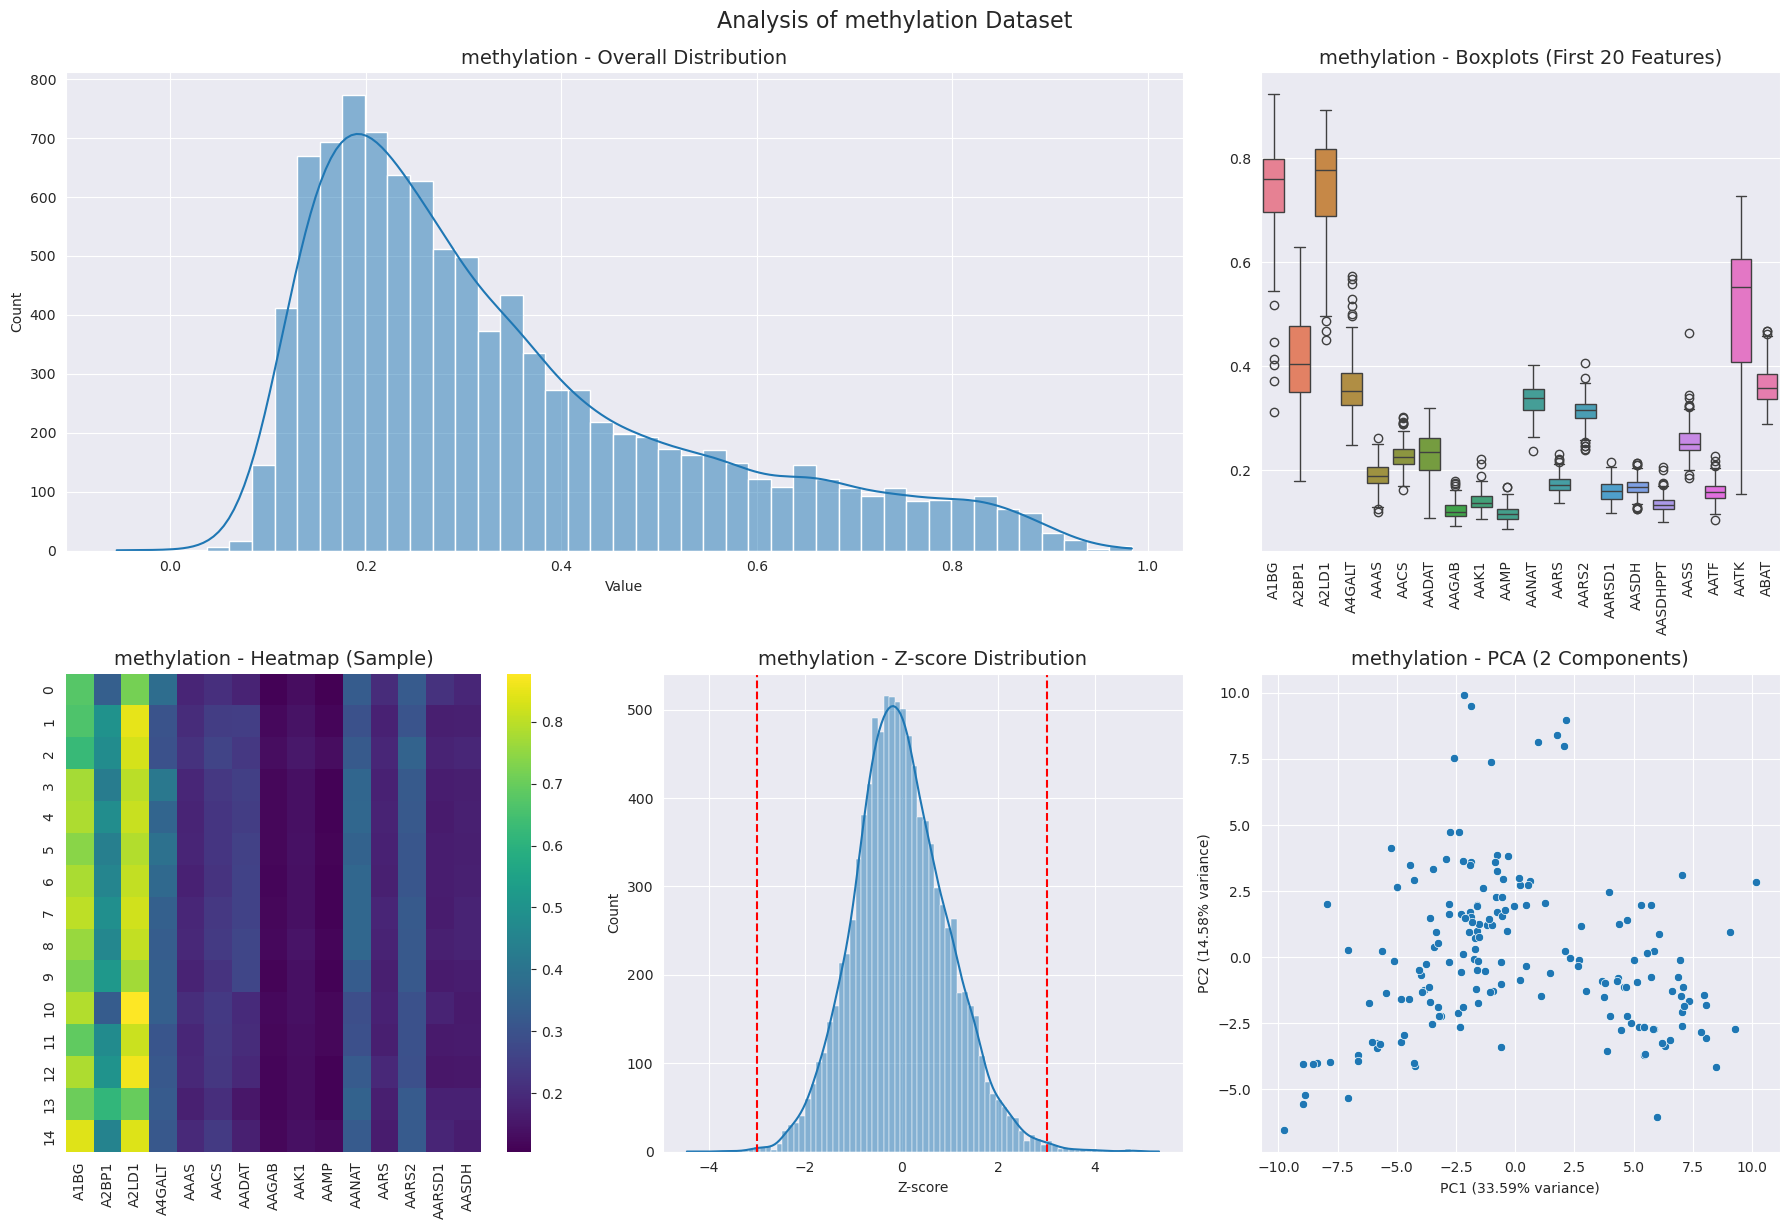

Analysing metabolomics dataset...


/tmp/ipykernel_339139/2865015375.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(data.columns[:20], rotation=90)


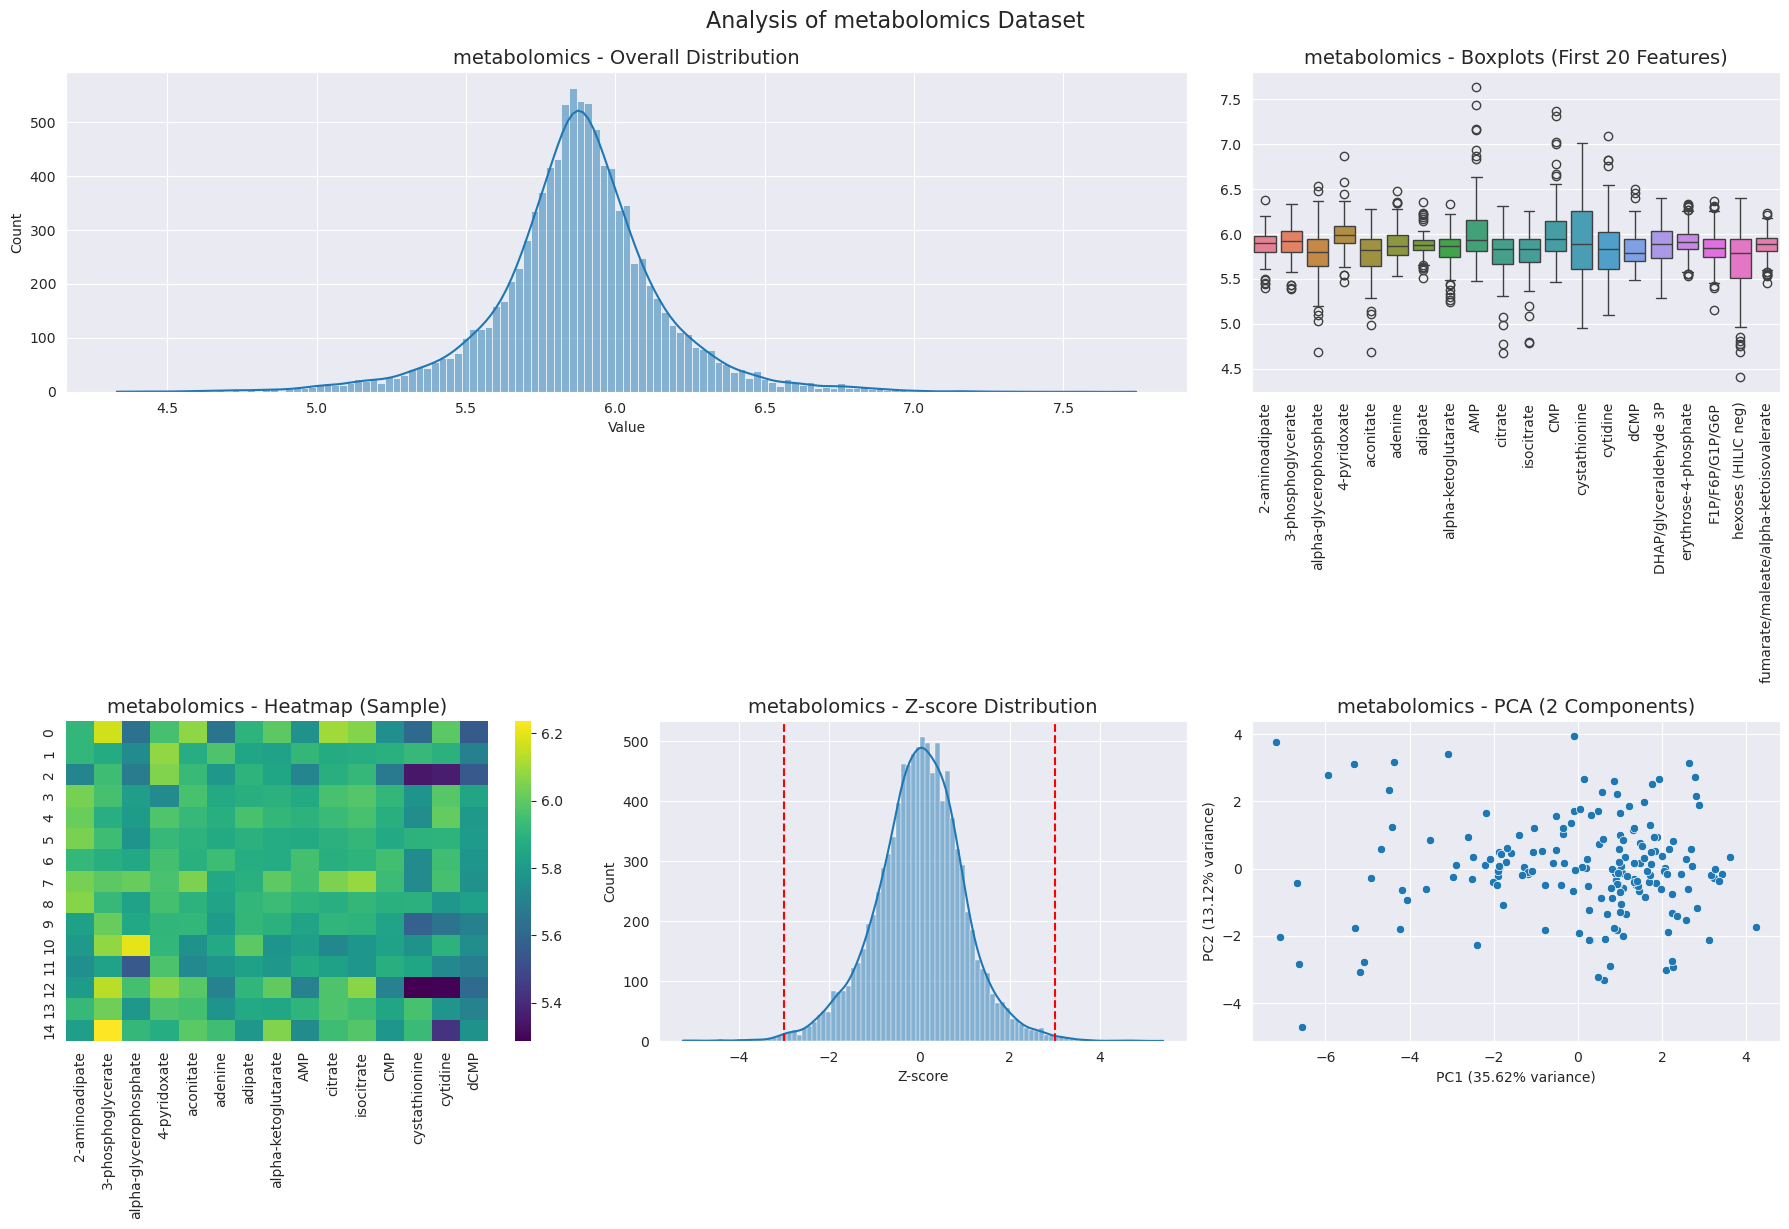

Analysing proteomics dataset...


/tmp/ipykernel_339139/2865015375.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(data.columns[:20], rotation=90)


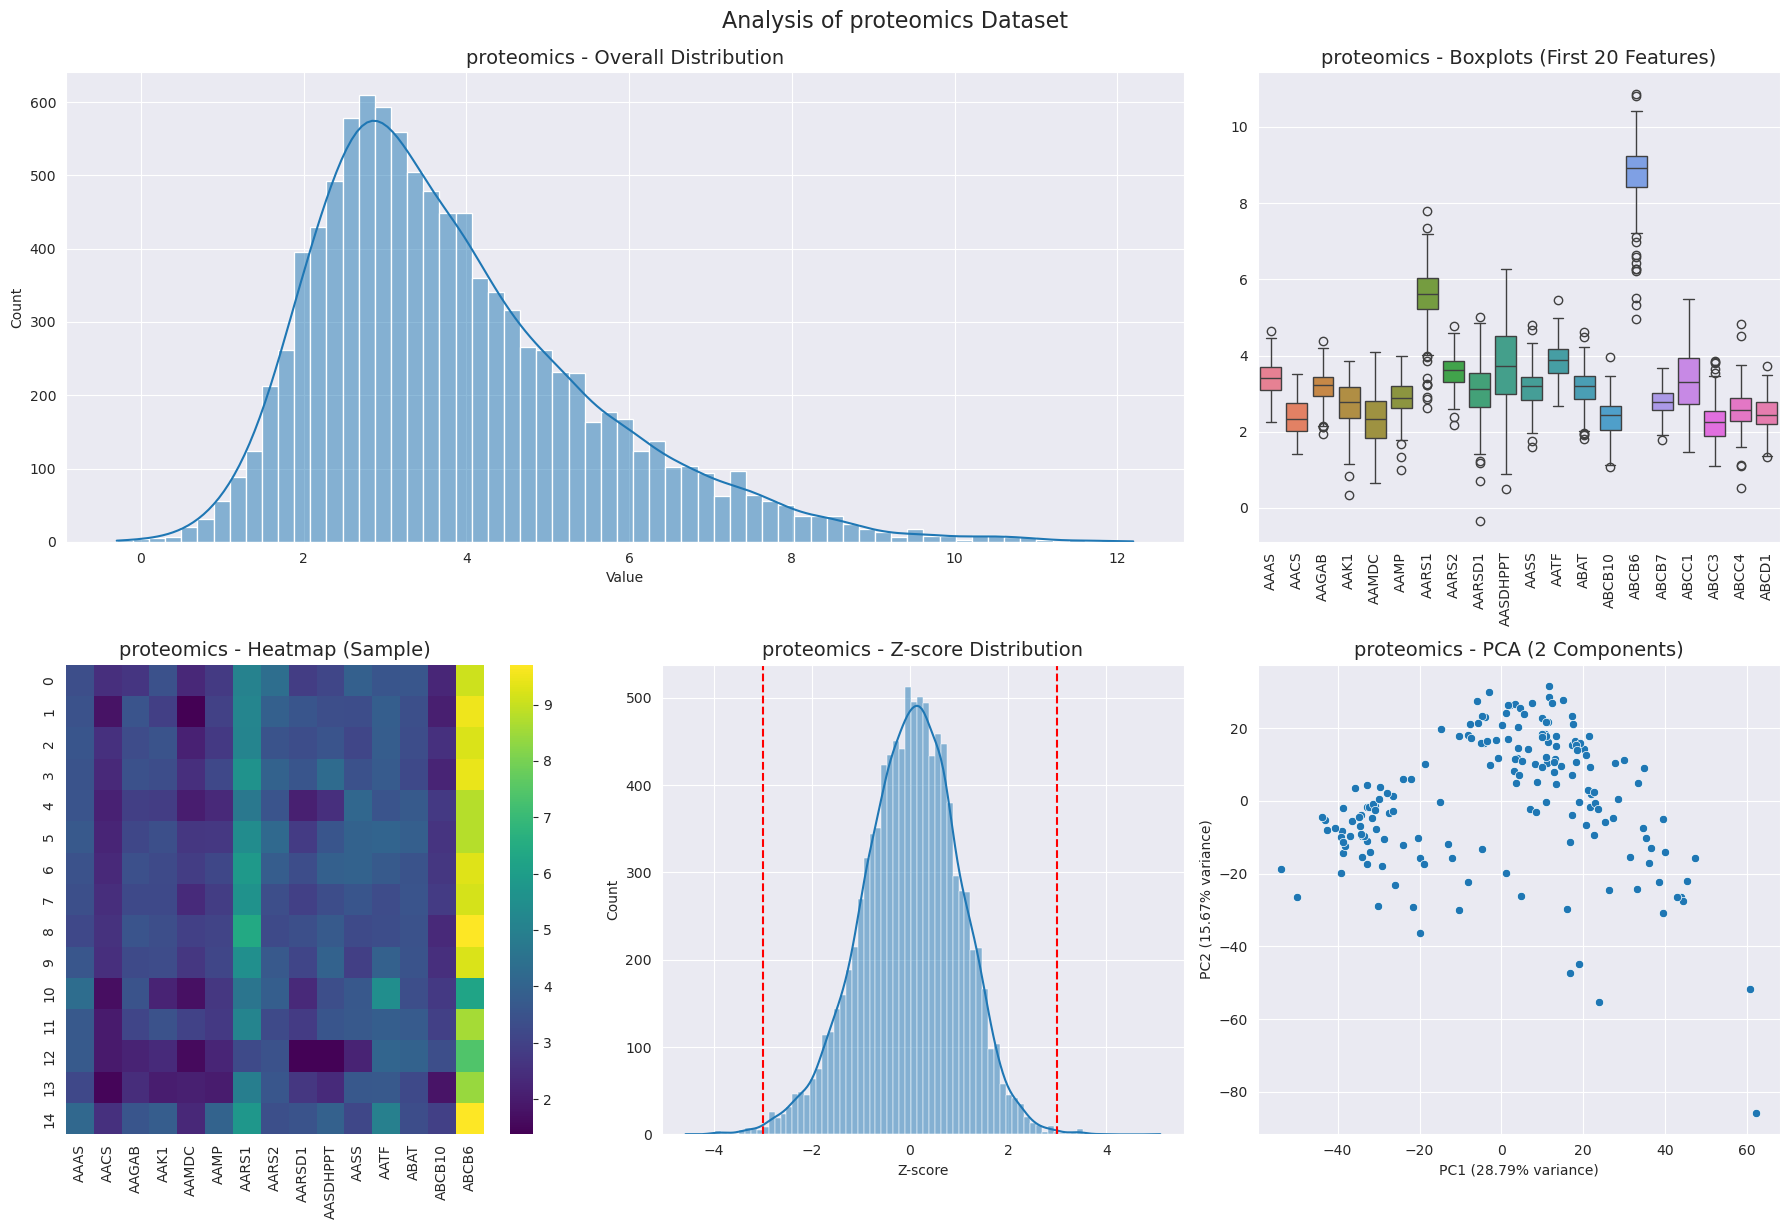

Analysing transcriptomics dataset...


/tmp/ipykernel_339139/2865015375.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(data.columns[:20], rotation=90)


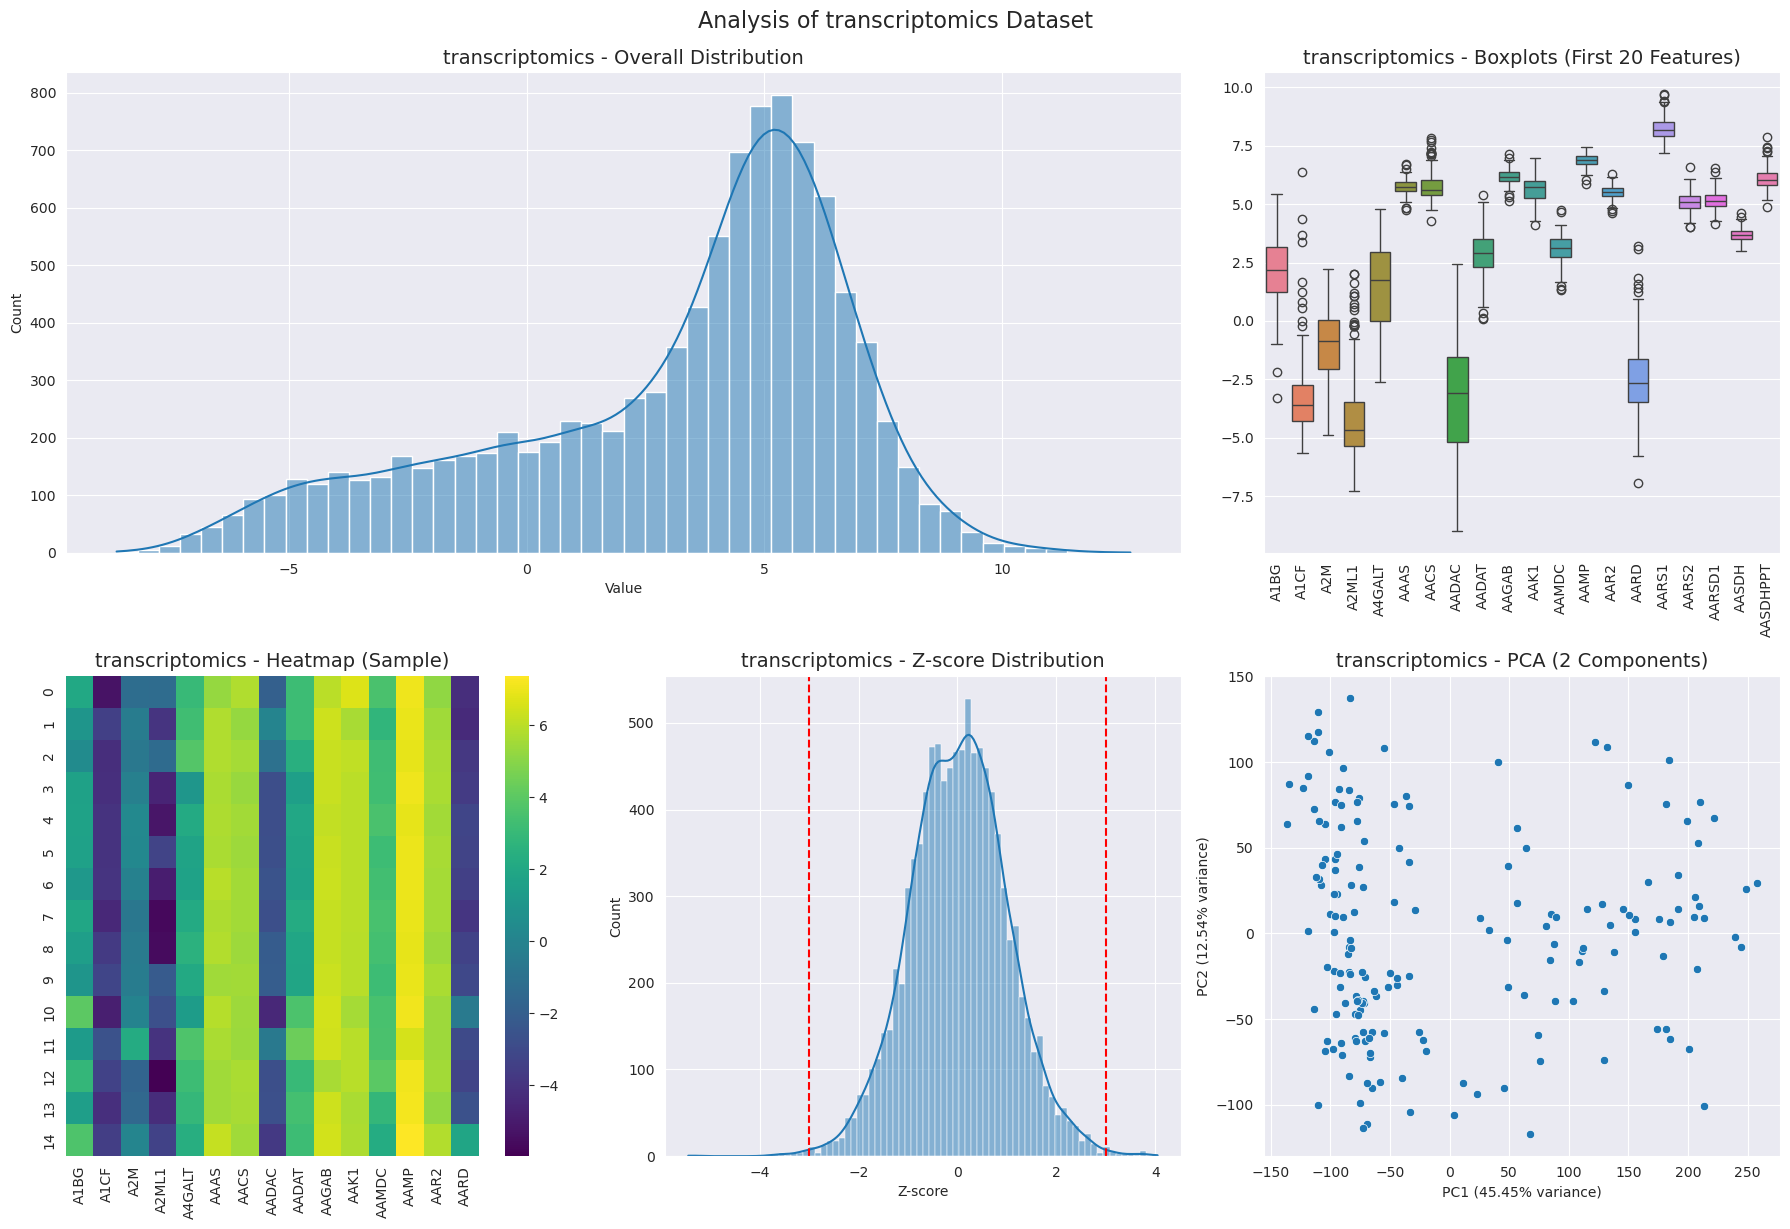

Analysing cnv dataset...


/tmp/ipykernel_339139/2865015375.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(data.columns[:20], rotation=90)


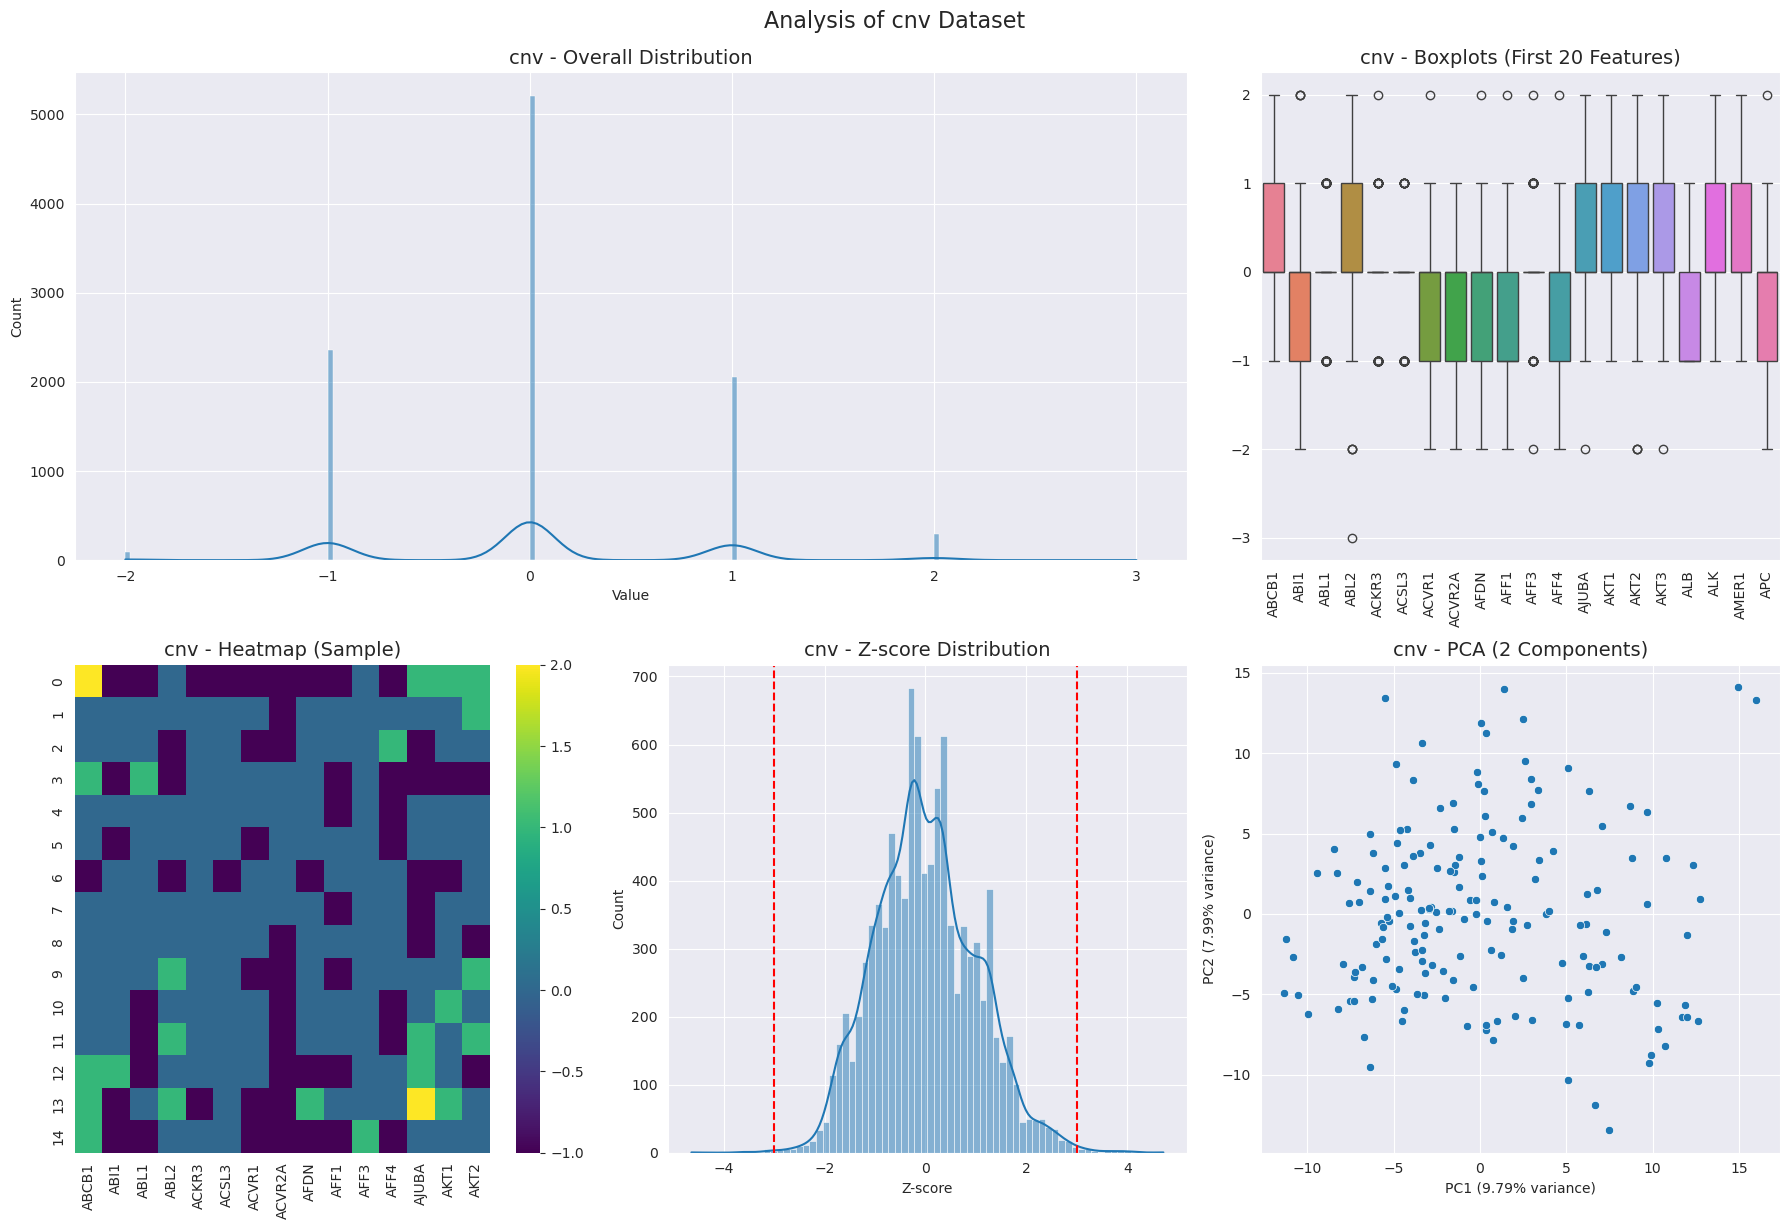

In [8]:
# Visualise data
def plot_distribution_and_outliers(dataset_name, dataset):
    """Visualise distribution and outliers for the datasets"""
    data = dataset.iloc[:, 1:]  # skip first column, as this is the sample ID
    
    # Plot
    fig = plt.figure(figsize=(18, 12))
    gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1])
    
    # 1. Distribution plot
    ax1 = plt.subplot(gs[0, 0:2])
    sampled_values = data.values.flatten()
    np.random.shuffle(sampled_values)
    sampled_values = sampled_values[:10000]  # Sample 1000 random values
    sns.histplot(sampled_values, kde=True, ax=ax1)
    ax1.set_title(f"{dataset_name} - Overall Distribution", fontsize=14)
    ax1.set_xlabel("Value")
    ax1.set_ylabel("Count")
    
    # 2. Boxplot for first 20 features
    ax2 = plt.subplot(gs[0, 2])
    sns.boxplot(data=data.iloc[:, :20], ax=ax2)
    ax2.set_title(f"{dataset_name} - Boxplots (First 20 Features)", fontsize=14)
    ax2.set_xticklabels(data.columns[:20], rotation=90)
    
    # 3. Heatmap of the data: samples vs features
    ax3 = plt.subplot(gs[1, 0])
    sample_data = data.iloc[:15, :15]
    sns.heatmap(sample_data, cmap="viridis", ax=ax3)
    ax3.set_title(f"{dataset_name} - Heatmap (Sample)", fontsize=14)
    
    # 4. Z-score distribution to identify outliers
    ax4 = plt.subplot(gs[1, 1])
    z_data = data.apply(zscore)
    z_flattened = z_data.values.flatten()
    np.random.shuffle(z_flattened)
    z_flattened = z_flattened[:10000]  # Sample 1000 for better visualisation
    sns.histplot(z_flattened, kde=True, ax=ax4)
    ax4.axvline(x=3, color="r", linestyle="--")
    ax4.axvline(x=-3, color="r", linestyle="--")
    ax4.set_title(f"{dataset_name} - Z-score Distribution", fontsize=14)
    ax4.set_xlabel("Z-score")
    ax4.set_ylabel("Count")
    
    # 5. PCA
    ax5 = plt.subplot(gs[1, 2])
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)
    sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], ax=ax5)
    ax5.set_title(f"{dataset_name} - PCA (2 Components)", fontsize=14)
    ax5.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
    ax5.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)")
    
    plt.tight_layout()
    plt.suptitle(f"Analysis of {dataset_name} Dataset", fontsize=16, y=1.02)
    return fig, z_data


# Plot for all datasets
for dataset_name, dataset in datasets.items():
    print(f"Analysing {dataset_name} dataset...")
    fig1, z_data = plot_distribution_and_outliers(dataset_name, dataset)
    plt.figure(fig1.number)
    plt.show()

In [9]:
# Check outliers
z_scores = datasets["proteomics"].iloc[:, 1:].apply(zscore)

# Outliers (Z-score > 3 or < -3)
outliers = (z_scores.abs() > 3).sum(axis=0)

# Count the number of features for each number of outliers
outlier_counts = outliers.value_counts().sort_index()
for num_outliers, num_features in outlier_counts.items():
    print(f"{num_outliers} outliers: {num_features} features")


0 outliers: 1670 features
1 outliers: 1816 features
2 outliers: 1100 features
3 outliers: 276 features
4 outliers: 52 features
5 outliers: 8 features
